In [ ]:
import torch
from ultralytics import YOLO

def crop_image(image, box):
    additional_area = 1/10
    x_min, y_min, x_max, y_max = box
    width, height = image.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width*additional_area)
    y_min_2 = max(0, y_min - box_height*additional_area)
    x_max_2 = min(width, x_max + box_width*additional_area)
    y_max_2 = min(height, y_max + box_height*additional_area)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = image.crop(area)
    return cropped_img

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.set_device(0)


model_detect = YOLO('yolov8n.pt')
model_detect.classes = [0]

def recieve_box(image):
    results = model_detect(source = image, classes=0, show = False, imgsz=640, conf=0.2, iou=0.4, save = False, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    cropped_images = []
    for box in boxes:
        cropped_images.append(crop_image(image, box))
    return cropped_images

c:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from tqdm.auto import tqdm

def get_zoomed_dataset(data_dir):
    ds_demo = load_dataset("imagefolder", data_dir=data_dir)

    dict_detected = {'image' : [], 'labels': []}
    for i in tqdm(range(ds_demo['train'].num_rows)):
        img = recieve_box(ds_demo['train'][i]['image'])
        label = ds_demo['train'][i]['labels']
        if(len(img) > 0):
            dict_detected['image'].append(img[0])
            dict_detected['labels'].append(label)
    
    return Dataset.from_dict(dict_detected)


def get_dataset(need_split_train, data_train_dirs, data_test_dirs):
    train_datasets = []
    for data_dir in data_train_dirs:
        train_datasets.append(get_zoomed_dataset(data_dir))

    test_datasets = []
    for data_dir in data_test_dirs:
        test_datasets.append(get_zoomed_dataset(data_dir))

    ###
    for i in range(len(need_split_train)):
        if need_split_train[i]:
            train_datasets[i] = train_datasets[i].train_test_split(test_size=0.1)

            test_datasets.append(train_datasets[i]["test"])
            train_datasets[i] = train_datasets[i]["train"]
    ###
    
    ds_train_detected = concatenate_datasets(train_datasets)
    
    if not test_datasets:
        return ds_train_detected

    ds_test_detected = concatenate_datasets(test_datasets)
    return DatasetDict({
        'train': ds_train_detected,
        'test': ds_test_detected,
    })

In [5]:
need_split_train = [True]

data_train_dirs = [
    #"datasets\datasets_raw\shoplifting_images_2\\train",
    "datasets\datasets_raw\shoplifting_images_2\\valid",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/train",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/test",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/train",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/valid",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/test",
    ##"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_video_frames/frames"
    ]

data_test_dirs = [
    # "datasets\datasets_raw\shoplifting_images_2\\test",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/train",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/test",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/train",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/valid",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/test",
    ##"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_video_frames/frames"
    ]


ds_detected = get_dataset(need_split_train, data_train_dirs, data_test_dirs)

ds_detected.save_to_disk("datasets\datasets_cutted\shoplifting_images_2")

Saving the dataset (1/1 shards): 100%|██████████| 22/22 [00:00<00:00, 1646.88 examples/s]


In [6]:
from datasets import load_from_disk

ds_new = load_from_disk("datasets\datasets_cutted\shoplifting_images_2")

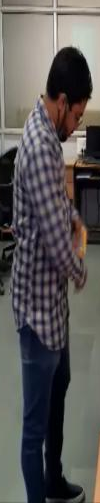

In [18]:
ds_new['train']['image'][0]